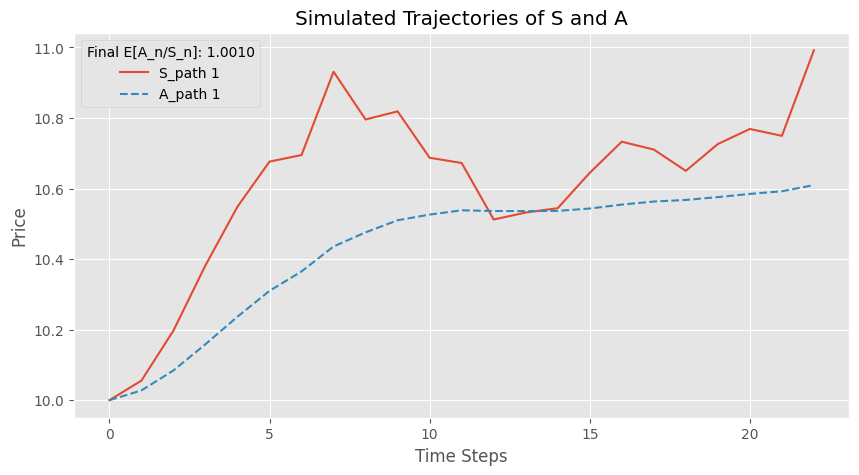

[I 2024-10-31 18:51:31,333] A new study created in memory with name: no-name-73001f45-449f-4a83-b692-f6723cf6c09a
[I 2024-10-31 18:51:31,342] Trial 0 finished with value: 1.0016659812810176 and parameters: {'a': 1.9593371874163343}. Best is trial 0 with value: 1.0016659812810176.
[I 2024-10-31 18:51:31,349] Trial 1 finished with value: 1.0021303423884764 and parameters: {'a': 1.3500474595511547}. Best is trial 1 with value: 1.0021303423884764.
[I 2024-10-31 18:51:31,357] Trial 2 finished with value: 1.0018016325148518 and parameters: {'a': 1.9708508026106073}. Best is trial 1 with value: 1.0021303423884764.
[I 2024-10-31 18:51:31,364] Trial 3 finished with value: 1.0044668400024255 and parameters: {'a': 1.053746711502976}. Best is trial 3 with value: 1.0044668400024255.
[I 2024-10-31 18:51:31,372] Trial 4 finished with value: 1.001347934572106 and parameters: {'a': 1.2826998538990106}. Best is trial 3 with value: 1.0044668400024255.
[I 2024-10-31 18:51:31,379] Trial 5 finished with val

Optimal 'a' (Grid Search): 1.0526315789473684
Maximum Expected Ratio (Grid Search): 1.0046614551669264
Optimal 'a' (Bellman): 1.0526315789473684
Maximum Expected Ratio (Bellman): 1.0035748912169842


[I 2024-10-31 18:51:31,526] Trial 23 finished with value: 1.001284499279729 and parameters: {'a': 1.21863817145592}. Best is trial 22 with value: 1.010015332156142.
[I 2024-10-31 18:51:31,535] Trial 24 finished with value: 1.0014297427256538 and parameters: {'a': 1.1096770169880834}. Best is trial 22 with value: 1.010015332156142.
[I 2024-10-31 18:51:31,543] Trial 25 finished with value: 1.0016741326699499 and parameters: {'a': 1.0973701062736145}. Best is trial 22 with value: 1.010015332156142.
[I 2024-10-31 18:51:31,551] Trial 26 finished with value: 1.0089296929474185 and parameters: {'a': 1.0081422117567427}. Best is trial 22 with value: 1.010015332156142.
[I 2024-10-31 18:51:31,559] Trial 27 finished with value: 1.0014876493776803 and parameters: {'a': 1.3829811103992782}. Best is trial 22 with value: 1.010015332156142.
[I 2024-10-31 18:51:31,568] Trial 28 finished with value: 1.0019427622713335 and parameters: {'a': 1.2677399023464693}. Best is trial 22 with value: 1.010015332156

Optimal 'a' (Optuna): 1.012370376282432
Maximum Expected Ratio (Optuna): 1.010015332156142


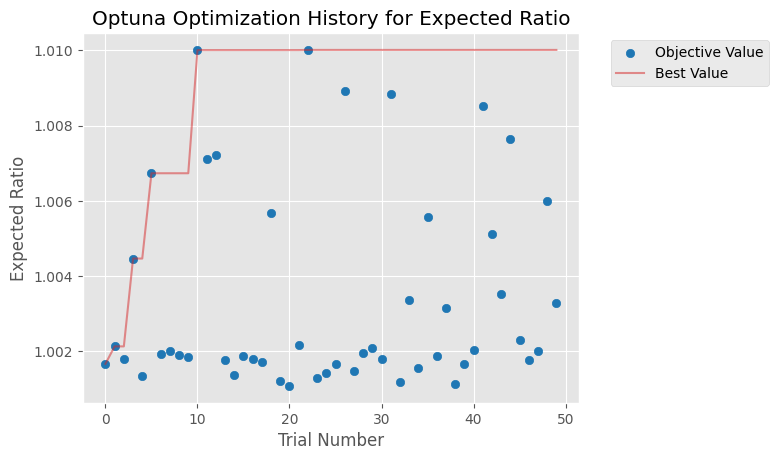

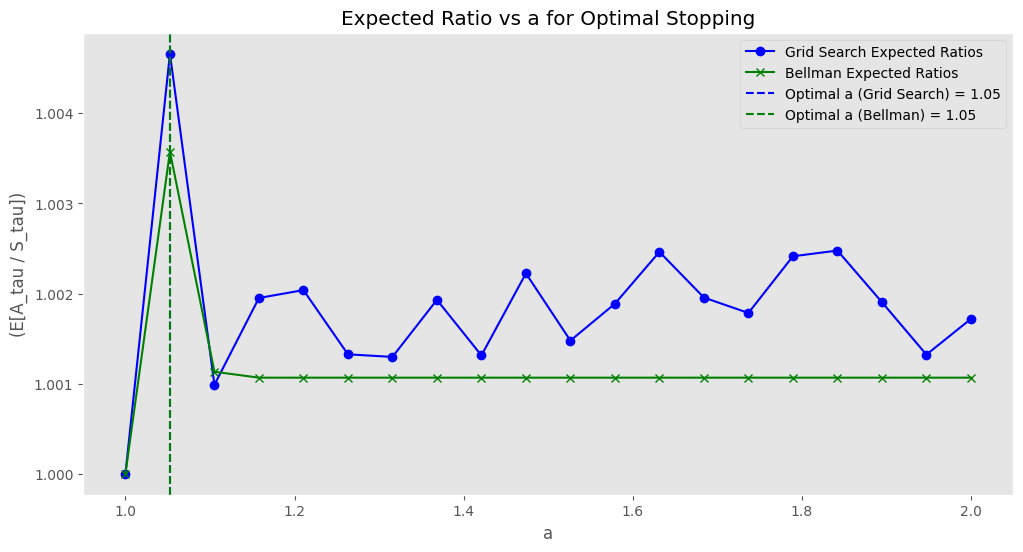

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

class Simulator:
    def __init__(self, S0=10, sigma=0.2, delta_t=1 / 252, N=22, num_simulations=10000):
        self.S0 = S0
        self.sigma = sigma
        self.delta_t = delta_t
        self.N = N
        self.num_simulations = num_simulations
        self.time_steps = np.arange(N + 1)

    def simulate_multiple_trajectories(self):
        random_shocks = np.random.normal(0, 1, (self.N, self.num_simulations))
        price_changes = np.exp((-0.5 * self.sigma ** 2 * self.delta_t) +
                               (self.sigma * np.sqrt(self.delta_t) * random_shocks))

        S_paths = np.vstack([np.ones(self.num_simulations) * self.S0, price_changes])
        S_paths = np.cumprod(S_paths, axis=0)
        A_paths = np.cumsum(S_paths, axis=0) / (self.time_steps[:, None] + 1)

        return S_paths, A_paths

    def plot_trajectories(self):
        S_paths, A_paths = self.simulate_multiple_trajectories()
        expected_ratios = np.mean(A_paths / S_paths, axis=1)  # Compute the mean ratio at each time step

        plt.figure(figsize=(10, 5))
        # Plot a single trajectory for clarity
        plt.plot(self.time_steps, S_paths[:, 0], label=f'S_path 1')
        plt.plot(self.time_steps, A_paths[:, 0], label=f'A_path 1', linestyle='--')
        # Add expected ratio at final time step to the legend
        plt.title('Simulated Trajectories of S and A')
        plt.xlabel('Time Steps')
        plt.ylabel('Price')
        plt.legend(title=f'Final E[A_n/S_n]: {expected_ratios[-1]:.4f}')
        plt.show()

    def compute_expected_ratio(self, a):
        S_paths, A_paths = self.simulate_multiple_trajectories()
        stopping_conditions = A_paths >= a * S_paths
        stopping_times = np.argmax(stopping_conditions, axis=0)
        stopping_times = np.where(np.any(stopping_conditions, axis=0), stopping_times, self.N)

        A_tau = np.take_along_axis(A_paths, stopping_times[None, :], axis=0).flatten()
        S_tau = np.take_along_axis(S_paths, stopping_times[None, :], axis=0).flatten()

        expected_ratio = np.mean(A_tau / S_tau)
        return expected_ratio

    def find_optimal_a_grid_search(self, a_values):
        expected_ratios = [self.compute_expected_ratio(a) for a in a_values]
        optimal_index = np.argmax(expected_ratios)
        return a_values[optimal_index], expected_ratios[optimal_index], expected_ratios

    def bellman(self, S_paths, A_paths, N, a_values):
        expected_ratios = []

        for a in a_values:
            V = np.zeros((N + 1, S_paths.shape[1]))

            V[-1] = A_paths[-1] / S_paths[-1]

            for n in reversed(range(N)):
                stop = A_paths[n] / S_paths[n]
                continue_value = V[n + 1]

                V[n] = np.where(A_paths[n] >= a * S_paths[n], stop, continue_value)

            expected_ratio = np.mean(V[0])
            expected_ratios.append(expected_ratio)

        optimal_index = np.argmax(expected_ratios)
        optimal_a_bellman = a_values[optimal_index]
        max_expected_ratio = expected_ratios[optimal_index]

        return optimal_a_bellman, max_expected_ratio, expected_ratios

def objective(trial):
    simulator = Simulator(S0=10, sigma=0.2, delta_t=1 / 252, N=22, num_simulations=10000)
    a = trial.suggest_float('a', 1.0, 2.0)
    expected_ratio = simulator.compute_expected_ratio(a)
    return expected_ratio

# Running the entire code with Optuna, Bellman, and Grid Search
def main():
    simulator = Simulator(S0=10, sigma=0.2, delta_t=1 / 252, N=22, num_simulations=10000)

    # Plot trajectories
    simulator.plot_trajectories()

    # Grid Search Method
    a_values = np.linspace(1.0, 2.0, 20)
    optimal_a_grid, max_expected_ratio_grid, expected_ratios_grid = simulator.find_optimal_a_grid_search(a_values)

    print(f"Optimal 'a' (Grid Search): {optimal_a_grid}")
    print(f"Maximum Expected Ratio (Grid Search): {max_expected_ratio_grid}")

    # Bellman Method
    S_paths, A_paths = simulator.simulate_multiple_trajectories()
    optimal_a_bellman, max_expected_ratio_bellman, expected_ratios_bellman = simulator.bellman(S_paths, A_paths, simulator.N, a_values)

    print(f"Optimal 'a' (Bellman): {optimal_a_bellman}")
    print(f"Maximum Expected Ratio (Bellman): {max_expected_ratio_bellman}")

    # Optuna Method
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Optimal 'a' (Optuna):", study.best_params['a'])
    print("Maximum Expected Ratio (Optuna):", study.best_value)

    # We plot the optimization strategy for Optuna 
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optuna Optimization History for Expected Ratio")
    plt.xlabel("Trial Number")
    plt.ylabel("Expected Ratio")
    plt.show()

    # Plot Expected Ratios for Grid Search and Bellman
    plt.figure(figsize=(12, 6))
    plt.plot(a_values, expected_ratios_grid, label="Grid Search Expected Ratios", marker='o', color='blue')
    plt.plot(a_values, expected_ratios_bellman, label="Bellman Expected Ratios", marker='x', color='green')
    plt.axvline(optimal_a_grid, color='blue', linestyle='--', label=f'Optimal a (Grid Search) = {optimal_a_grid:.2f}')
    plt.axvline(optimal_a_bellman, color='green', linestyle='--', label=f'Optimal a (Bellman) = {optimal_a_bellman:.2f}')
    plt.xlabel('a')
    plt.ylabel('(E[A_tau / S_tau])')
    plt.title('Expected Ratio vs a for Optimal Stopping')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()